# Étape 1 : Comprendre les données & les collecter
- Objectifs :
    - Explorer StackExchange Data Explorer
    - Tester l’API (StackAPI ou StackExchange API)

- Sous-tâches :
    - 1. Formuler et exécuter une requête SQL sur StackExchange Data Explorer pour extraire 50 000 questions avec :
        - Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount
        - Contraintes de qualité (min 5 tags, au moins 1 réponse…)
        
    - 2. En parallèle, tester l’API pour extraire 50 questions taguées “python” avec score >= 50
        - Récupérer les infos principales : title, tags, score, date
        - Évaluer la facilité d’utilisation de l’API
    - 3. Respecter le RGPD (pas de données personnelles, anonymisation si besoin)
    - 4. Nettoyer le dataset (suppression HTML, balises inutiles, etc.)

In [104]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
df = pd.read_csv('QueryResults.csv')

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          50000 non-null  object 
 1   Body           50000 non-null  object 
 2   Tags           50000 non-null  object 
 3   Id             50000 non-null  int64  
 4   Score          50000 non-null  int64  
 5   ViewCount      50000 non-null  int64  
 6   FavoriteCount  0 non-null      float64
 7   AnswerCount    50000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.1+ MB


In [110]:
# Nettoyons le texte (HTML dans Body, extraction des tags, etc.)
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable <code...,<c#><floating-point><type-conversion><double><...,4,815,81478,NaN,13
1,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,11,1655,205534,NaN,42
2,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,13,726,322686,NaN,28
3,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,19,356,73180,NaN,23
4,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,25,178,16907,NaN,9


In [112]:
# !pip install beautifulsoup4 !pip install lxml
from bs4 import BeautifulSoup
import re

from stackapi import StackAPI
import requests

In [114]:
# Nettoyer le texte HTML contenu dans Body
def cleaning_html(df, col ):
    '''Nettoie les balises html diponible dans une colonne spécifique d'un dataframe'''
    df[col] = df[col].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return df

def remove_urls(text):
    # Supprime les URLs classiques commençant par http ou https
    return re.sub(r"https?://\S+|www\.\S+", "", text)
    
# Transformer les Tags de string à liste
def cleaning_tag(df, col):
    '''Transformer les Tags de string de la colonne du dataframe à une liste'''
    df[col] = df[col].apply(lambda x: re.findall(r'<([^>]+)>', x))
    return df

In [116]:
df = cleaning_html(df, 'Body')
df['Title'] = df['Title'].apply(remove_urls)
df['Body'] = df['Body'].apply(remove_urls)
df = cleaning_tag(df, 'Tags')

In [118]:
df = df.drop(columns=["FavoriteCount"])

In [17]:
def stackapi_method():
    # Initialiser l’API pour StackOverflow
    site = StackAPI('stackoverflow')
    # Récupérer les 50 questions taguées 'python' avec score >= 50
    questions = site.fetch('questions', tagged='python', sort='votes', min=50, pagesize=50)
    # Convertir en DataFrame
    df = pd.DataFrame(questions['items'])
    return df



def request_method():
    # 1. Définir l’adresse de l’API (on lui parle via cette URL)
    url = "https://api.stackexchange.com/2.3/questions"
    
    # 2. Spécifier ce qu’on veut demander : les paramètres de la requête
    params = {
        "order": "desc",          # On veut les questions triées par score décroissant
        "sort": "votes",          # On trie par nombre de votes
        "tagged": "python",       # On ne veut que les questions taguées "python"
        "min": 50,                # On veut que celles avec un score minimum de 50
        "site": "stackoverflow",  # Le site qu’on interroge est StackOverflow
        "pagesize": 50            # On limite à 50 résultats
    }
    
    # 3. Envoyer la requête à l’API
    response = requests.get(url, params=params)
    
    # 4. Récupérer les données (réponse) en format JSON
    data = response.json()
    
    # 5. Extraire les questions (elles sont dans la clé "items")
    items = data["items"]
    
    # 6. Créer un DataFrame pour voir les données facilement
    df = pd.DataFrame([{
        "title": item["title"],          # Titre de la question
        "score": item["score"],          # Score de la question
        "tags": item["tags"],            # Tags associés
        "link": item["link"],            # Lien vers la question
        "is_answered": item["is_answered"]  # Si elle a une réponse acceptée
    } for item in items])
    return df


In [19]:
df_api = stackapi_method()

In [21]:
df_api = df_api[['title', 'tags', 'score', 'creation_date']]
df_api.head()

,title,tags,score,creation_date
0,What does the &quot;yield&quot; keyword do in ...,"[python, iterator, generator, yield]",13080,1224800471
1,What does if __name__ == &quot;__main__&quot;:...,"[python, namespaces, program-entry-point, pyth...",8381,1231301460
2,Does Python have a ternary conditional operator?,"[python, operators, conditional-operator]",8083,1230366738
3,What are metaclasses in Python?,"[python, oop, metaclass, python-class, python-...",7498,1221804646
4,How do I check whether a file exists without e...,"[python, file, file-exists]",7299,1221656100


In [23]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          250 non-null    object
 1   tags           250 non-null    object
 2   score          250 non-null    int64 
 3   creation_date  250 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 7.9+ KB


In [120]:
df_api.to_csv('api_stackoverflow.csv', index=False)
df.to_csv('stackoverflow.csv', index=False)

# EDA
- **Objectif :** comprendre au maximum les données dont on dispose pour définir une stratégie de modélisation. 

- **I - Analyse de la forme:**
  - Identification de la target : `Tags`
  - Nombre des lignes et de colonnes : (50000 lignes, 7 colonnes)
  - Identification des valeurs manquantes : 0 Valeur manquante
  - Types de variables : 4 int (entiers) et 3 object (chaine de caractère)
 
- **II - Analyse du fond:**
  - ***Visualisation de la target :*** toutes les tags de notre jeu de donnée ont une taille identique 5 tags et ('c#', 10410), ('.net', 7051), ('java', 5252), ('asp.net', 3721) sont les 4 première tag qui apparaissent le plus.
  - ***Compréhension des différentes variables (recherche) :*** les variables (`Id, Score, ViewCount, AnswerCount`) qui vont pas nous servir à grand chose dans notre modelisaton. Car ce sont des données connues qu'après publication d'une question (elles nous ont servie juste a récuperer des données de qualité pour notre entrainement) 
  - ***Visualisation de quelques features :*** la distribution len(`body`, `title`) est asymetrique -> longuer max (3990,31) -> besoin de nettoyage (token, lemme, stem, unique...) car la pressence de beaucoup de stopwords
    - Variable `Title` : les 4 mots qui sont les plus present ('to', 16279), ('a', 15034), ('in', 13360), ('How', 9187).
    - Variable `Body` : les 4 mots qui sont les plus present ('the', 311231), ('to', 220893), ('I', 183601), ('a', 166634).
    -  Combiner le `title` et le `body` en un seul champ texte présente deux avantages majeurs : Cela empêche les mots répétés dans les deux colonnes d'avoir un poids excessif lors de l'entraînement du modèle. Travailler sur un document unique facilite et homogénéise les opérations de nettoyage et de normalisation (comme la lemmatisation ou la suppression des mots vides), évitant ainsi de gérer deux chaînes de texte avec des règles potentiellement différentes.
  - ***Identification des outliers et doublons :*** Pas de doublons dans notre dataset.

- ### Conclusion
Les données sont de bonne qualité (pas de valeurs manquantes, pas de doublons). La variable `Tags` est bien formatée pour une modélisation multilabel. Les distributions des textes (`Body`, `Title`) sont asymétriques → prévoir du prétraitement (lemmatisation, suppression de stopwords). Les variables `Score`, `ViewCount`, `AnswerCount` ont été utiles pour filtrer les données mais ne seront pas utilisées dans le modèle. L’API StackExchange est bien documentée, permet d'accéder à des données ciblées, mais limitée en volume (100 items/page, 300 requêtes max/jour).

## I - Analyse de la forme

In [122]:
df.shape

(50000, 7)

In [124]:
df.isna().sum()

Title          0
Body           0
Tags           0
Id             0
Score          0
ViewCount      0
AnswerCount    0
dtype: int64

## II - Analyse du fond

In [18]:
from wordcloud import WordCloud
from nltk.probability import FreqDist

In [20]:
def restitution_corpus(df, text, c_list=True):
    if c_list:
        # Joint les listes SANS modifier le DataFrame
        texts = df[text].dropna().apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
        return ' '.join(texts)
    return ' '.join(df[text].dropna().astype(str))
    

In [22]:
df['lg_tag'] = df['Tags'].apply(len)
df['lg_title'] = df['Title'].str.split().str.len()
df['lg_body'] = df['Body'].str.split().str.len()

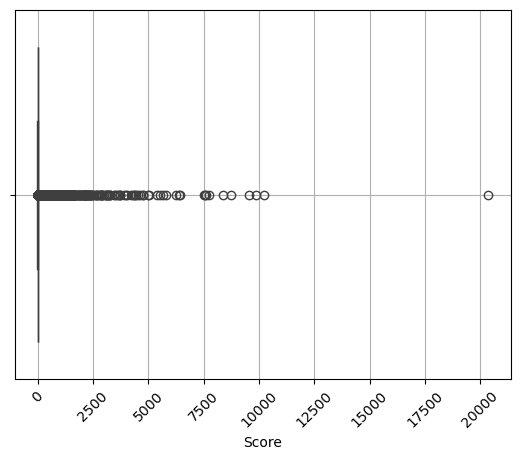

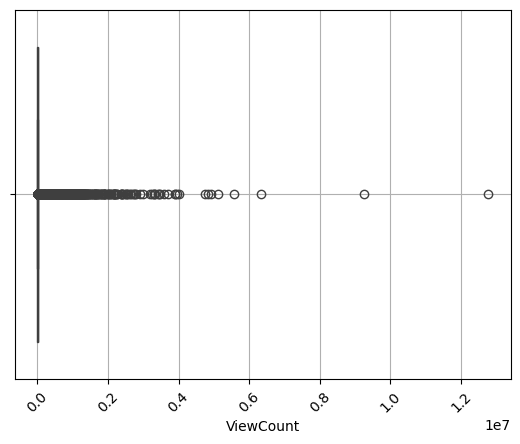

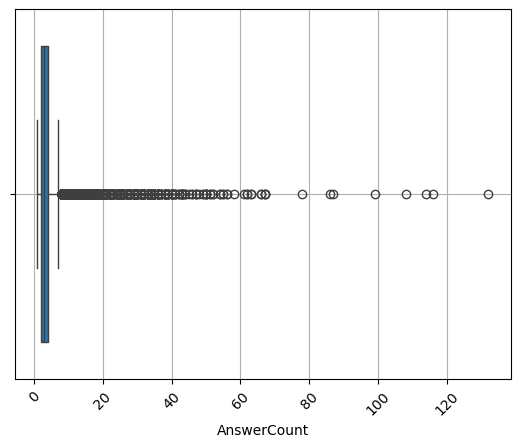

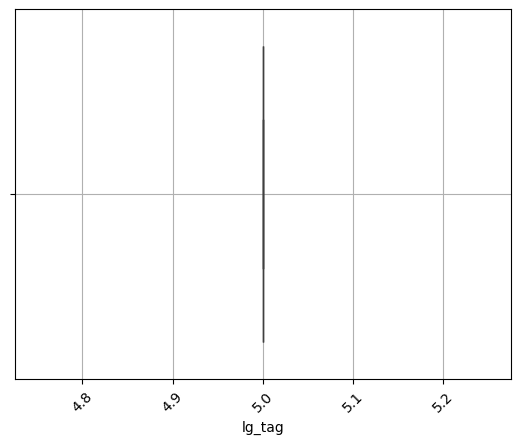

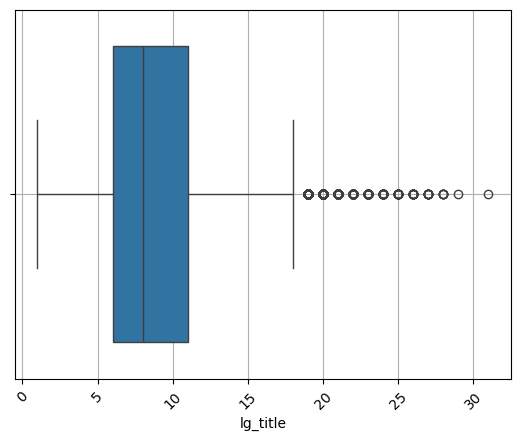

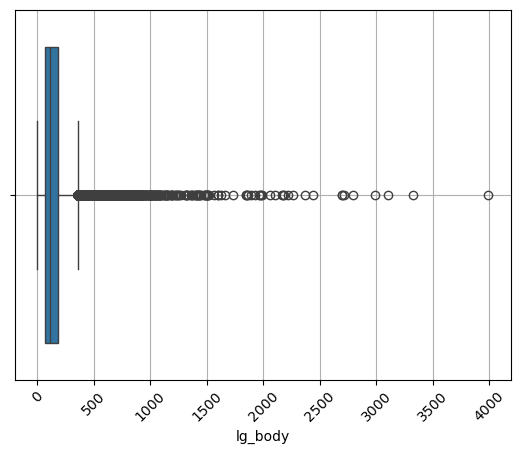

In [24]:
# Etudes des outlier de toutes nous variables
n_columns = list(df.select_dtypes(exclude = 'object').columns)
for col in n_columns:
    if col != 'Id':
        sns.boxplot(x=df[col])
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()

In [26]:
df['lg_tag'].value_counts()

lg_tag
5    50000
Name: count, dtype: int64

In [28]:
df[n_columns].describe()

,Id,Score,ViewCount,AnswerCount,lg_tag,lg_title,lg_body
count,5.000000e+04,50000.000000,5.000000e+04,50000.000000,50000.0,50000.00000,50000.000000
mean,1.363335e+06,26.562060,2.497281e+04,3.726360,5.0,8.87048,147.331940
std,6.909240e+05,221.509384,1.557688e+05,4.140211,0.0,3.73583,132.874469
min,4.000000e+00,-8.000000,3.900000e+01,1.000000,5.0,1.00000,0.000000
25%,7.971365e+05,1.000000,1.085000e+03,2.000000,5.0,6.00000,69.000000
50%,1.403590e+06,3.000000,2.790000e+03,3.000000,5.0,8.00000,114.000000
75%,1.972330e+06,8.000000,8.856000e+03,4.000000,5.0,11.00000,184.000000
max,2.474556e+06,20365.000000,1.277512e+07,132.000000,5.0,31.00000,3990.000000


In [88]:
# Affichons maintenant en wordcloud 
c_tags = restitution_corpus(df, 'Tags')
c_title = restitution_corpus(df, 'Title', c_list=False)
c_body = restitution_corpus(df, 'Body', c_list=False)

[('c#', 10410), ('.net', 7051), ('java', 5252), ('asp.net', 3721), ('c++', 3715), ('javascript', 3275), ('php', 3168), ('sql', 2372), ('python', 2336), ('jquery', 2265), ('iphone', 2184), ('html', 1946), ('sql-server', 1914), ('wpf', 1827), ('c', 1692), ('windows', 1628), ('database', 1529), ('mysql', 1516), ('objective-c', 1506), ('performance', 1291), ('xml', 1256), ('linux', 1236), ('winforms', 1174), ('ajax', 1137), ('vb.net', 1106), ('visual-studio', 1092), ('css', 1053), ('multithreading', 1011), ('ruby-on-rails', 954), ('asp.net-mvc', 941)]


<Axes: xlabel='Samples', ylabel='Counts'>

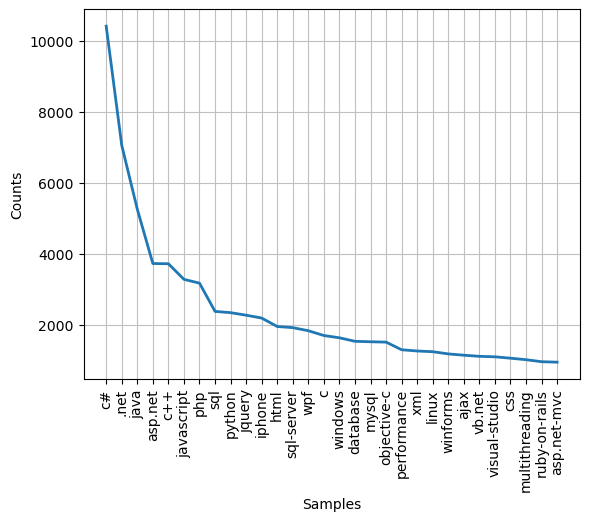

In [32]:
# Etudion la distribution de notre variable cible tags
fq_tags = FreqDist(c_tags.split())
print(fq_tags.most_common(30))
fq_tags.plot(30, cumulative=False)

[('to', 16279), ('a', 15034), ('in', 13360), ('How', 9187), ('the', 7122), ('and', 6108), ('with', 5815), ('of', 5329), ('for', 5146), ('I', 4627), ('on', 4126), ('from', 3920), ('an', 3307), ('is', 2929), ('using', 2864), ('do', 2801), ('-', 2612), ('can', 2012), ('or', 1854), ('when', 1735), ('not', 1724), ('Is', 1662), ('What', 1636), ('use', 1524), ('file', 1496), ('C#', 1452), ('SQL', 1377), ('way', 1330), ('it', 1196), ('get', 1107)]


<Axes: xlabel='Samples', ylabel='Counts'>

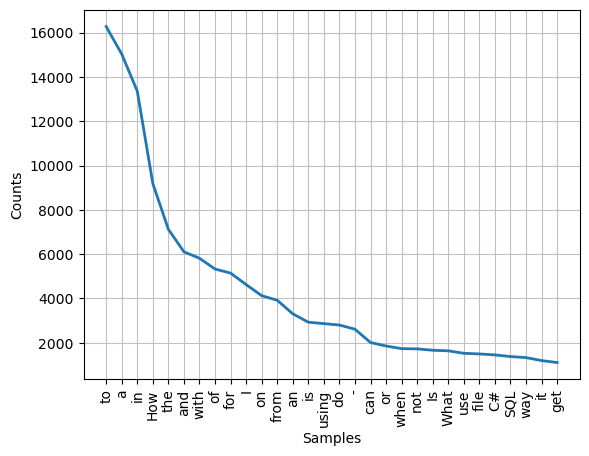

In [34]:
# Etudion la distribution de notre variable title
fq_tags = FreqDist(c_title.split())
print(fq_tags.most_common(30))
fq_tags.plot(30, cumulative=False)

[('the', 308239), ('to', 218674), ('I', 181913), ('a', 165012), ('and', 107020), ('is', 101436), ('in', 92252), ('of', 90973), ('that', 74035), ('=', 72322), ('it', 58128), ('for', 55627), ('this', 50733), ('have', 50059), ('with', 44575), ('{', 43653), ('on', 42903), ('be', 42795), ('}', 40838), ('my', 36229), ('but', 35887), ('an', 32664), ('not', 32156), ('as', 30973), ('if', 28637), ('can', 28629), ("I'm", 28244), ('using', 27683), ('from', 27618), ('or', 25896)]


<Axes: xlabel='Samples', ylabel='Counts'>

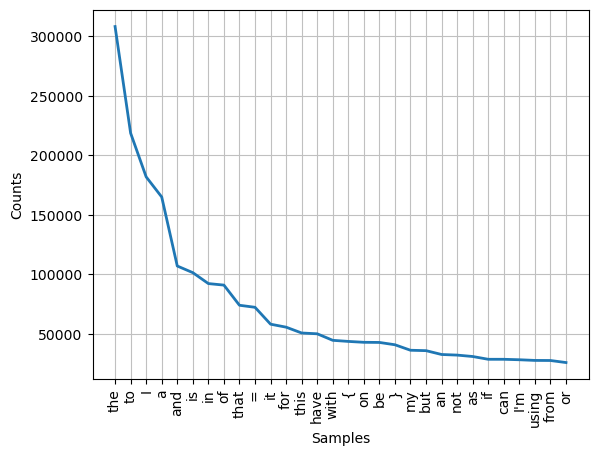

In [36]:
# Etudion la distribution de notre variable Body
fq_tags = FreqDist(c_body.split())
print(fq_tags.most_common(30))
fq_tags.plot(30, cumulative=False)

In [37]:
def visual_cloud():
    plt.figure(figsize = (9,6))
    # ajoutons interpolation = bilinear pour arrondir les angles
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
# creation d'un wordcloud.
wordcloud = WordCloud(
    random_state = 404,
    normalize_plurals = False,
    width = 600,
    height= 300,
    max_words = 300,
    stopwords = []
)

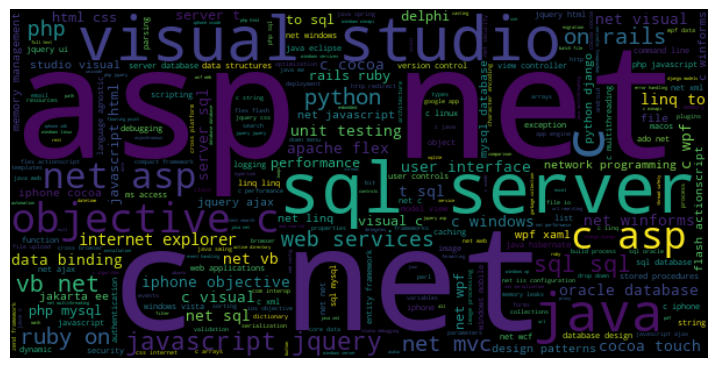

In [40]:
# utilison sur notre corpus
wordcloud.generate(c_tags)
visual_cloud()

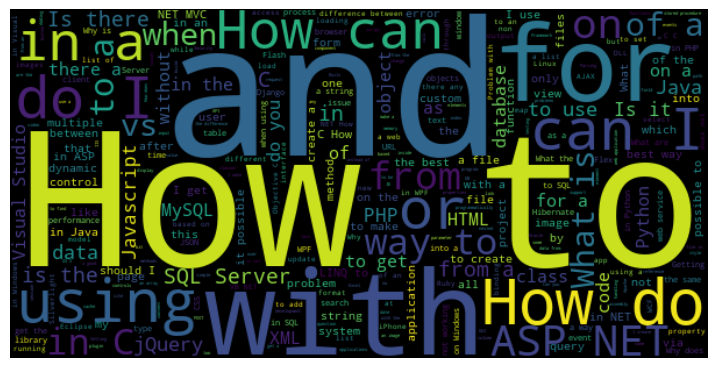

In [42]:
wordcloud.generate(c_title)
visual_cloud()

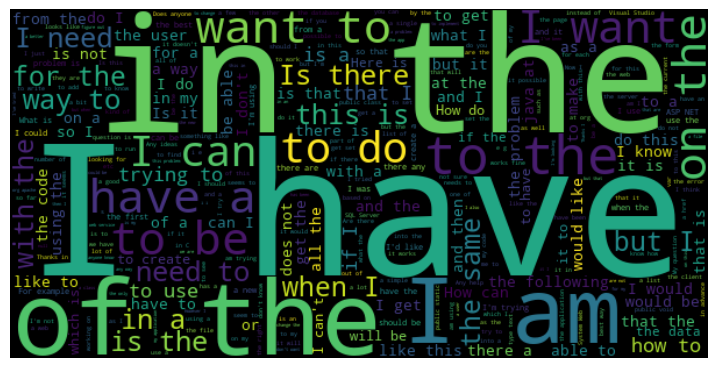

In [46]:
wordcloud.generate(c_body)
visual_cloud()

In [112]:
# Detection des dublons
df.duplicated(subset=['Title','Body']).sum()

np.int64(0)